In [1]:
import polars as pl
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime

pl.enable_string_cache()
pl.Config().set_tbl_cols(100)
pl.Config().set_tbl_rows(25)

polars.config.Config

In [2]:
%config InteractiveShell.ast_node_interactivity = 'last_expr_or_assign'

In [3]:
#Map route id to correct route name
route_mapping = {
    3: "2L",
    4: "2R",
    33: "3",
    17: "10",
    18: "11",
    23: "12",
    12: "16",
    13: "17",
    14: "18",
    30: "19",
    29: "21",
    38: "21 Tripper",
    777: "777"
}

#Map hex color to prediction status
color_mapping = {
    "#cf1625": "Early",
    "#39B139": "On Time",
    "#D58803": "Little Late",
    "#f3e413": "Very Late"
}

{'#cf1625': 'Early',
 '#39B139': 'On Time',
 '#D58803': 'Little Late',
 '#f3e413': 'Very Late'}

In [4]:
preds = pl.read_parquet("./data/2024-09-preds.parquet")

preds = preds.with_columns(pl.col("statuscolor").alias("statusName"))
preds = preds.with_columns(pl.col("statusName").replace_strict(color_mapping))

#Format the schedule time to be a datetime object
preds = preds.with_columns(
    pl.col('receiveTime').dt.convert_time_zone('America/Chicago'),
    pl.col('schedule').alias('scheduleStr'),
    pl.col('time').alias('timeStr'),
    pl.col('schedule').str.to_time(format='%I:%M%p', strict=False),
    pl.col('time').str.to_time(format='%I:%M%p', strict=False)
)

preds = preds.with_columns(pl.col('receiveTime').dt.combine(pl.col('time')).alias('time'),
                    pl.col('receiveTime').dt.combine(pl.col('schedule')).alias('schedule'))

#Correct for time columns hat are off by 24 hours
preds = preds.with_columns(
    pl.when(pl.col('time') - pl.col('receiveTime') > pl.duration(hours=12))
    .then(pl.col('time') - pl.duration(hours=24))
    .when(pl.col('time') - pl.col('receiveTime') < pl.duration(hours=-12))
    .then(pl.col('time') + pl.duration(hours=24))
    .otherwise(pl.col('time'))
    .alias('time')
)

#Correct for schedule times columns that are off by 24 hours
preds = preds.with_columns(
    pl.when(pl.col('schedule') - pl.col('receiveTime') > pl.duration(hours=12))
    .then(pl.col('schedule') - pl.duration(hours=24))
    .when(pl.col('schedule') - pl.col('receiveTime') < pl.duration(hours=-12))
    .then(pl.col('schedule') + pl.duration(hours=24))
    .otherwise(pl.col('schedule'))
    .alias('schedule')
)

preds = preds.with_columns(
    (pl.col("time") - pl.col("receiveTime")).alias("predictedDiff")
)

preds = preds.with_columns(
    (pl.col("schedule") - pl.col("receiveTime")).alias("scheduleDiff")
)


stopID,patternStopID,timePoint,minutes,time,status,schedule,scheduleNumber,statuscolor,direction,equipmentID,routeID,receiveTime,captureTime,__index_level_0__,statusName,scheduleStr,timeStr,predictedDiff,scheduleDiff
i64,i64,bool,i64,"datetime[μs, America/Chicago]",str,"datetime[μs, America/Chicago]",str,cat,cat,str,i64,"datetime[ns, America/Chicago]",datetime[ns],i64,str,str,str,duration[μs],duration[μs]
806,10612,false,1,2024-08-30 19:00:00 CDT,"""07:00PM""",2024-08-31 08:01:00 CDT,"""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 06:36:01 CDT,2024-09-01 00:00:01,20,"""Very Late""","""08:01AM""","""07:00PM""",-11h -36m -1s,1h 24m 59s
807,10613,false,1,2024-08-30 19:00:00 CDT,"""07:00PM""",2024-08-31 08:01:00 CDT,"""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 06:36:01 CDT,2024-09-01 00:00:01,21,"""Very Late""","""08:01AM""","""07:00PM""",-11h -36m -1s,1h 24m 59s
808,10614,false,2,2024-08-30 19:01:00 CDT,"""07:01PM""",2024-08-31 08:02:00 CDT,"""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 06:36:01 CDT,2024-09-01 00:00:01,22,"""Very Late""","""08:02AM""","""07:01PM""",-11h -35m -1s,1h 25m 59s
536,10615,true,3,2024-08-30 19:02:00 CDT,"""07:02PM""",2024-08-31 08:03:00 CDT,"""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 06:36:01 CDT,2024-09-01 00:00:01,23,"""Very Late""","""08:03AM""","""07:02PM""",-11h -34m -1s,1h 26m 59s
545,10616,false,4,2024-08-30 19:03:00 CDT,"""07:03PM""",2024-08-31 08:04:00 CDT,"""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 06:36:01 CDT,2024-09-01 00:00:01,24,"""Very Late""","""08:04AM""","""07:03PM""",-11h -33m -1s,1h 27m 59s
805,10611,true,1,2024-08-31 19:00:00 CDT,"""07:00PM""",2024-08-31 18:00:00 CDT,"""18:00:00-17""","""#f3e413""","""Outbound""","""502""",13,2024-08-31 18:59:46 CDT,2024-09-01 00:00:01,0,"""Very Late""","""06:00PM""","""07:00PM""",14s,-59m -46s
806,10612,false,2,2024-08-31 19:01:00 CDT,"""07:01PM""",2024-08-31 18:01:00 CDT,"""18:00:00-17""","""#f3e413""","""Outbound""","""502""",13,2024-08-31 18:59:46 CDT,2024-09-01 00:00:01,1,"""Very Late""","""06:01PM""","""07:01PM""",1m 14s,-58m -46s
807,10613,false,2,2024-08-31 19:01:00 CDT,"""07:01PM""",2024-08-31 18:01:00 CDT,"""18:00:00-17""","""#f3e413""","""Outbound""","""502""",13,2024-08-31 18:59:46 CDT,2024-09-01 00:00:01,2,"""Very Late""","""06:01PM""","""07:01PM""",1m 14s,-58m -46s
808,10614,false,3,2024-08-31 19:02:00 CDT,"""07:02PM""",2024-08-31 18:02:00 CDT,"""18:00:00-17""","""#f3e413""","""Outbound""","""502""",13,2024-08-31 18:59:46 CDT,2024-09-01 00:00:01,3,"""Very Late""","""06:02PM""","""07:02PM""",2m 14s,-57m -46s


In [5]:
preds['scheduleDiff'].describe()

statistic,value
str,str
"""count""","""7539593"""
"""null_count""","""28467"""
"""mean""","""0:00:34.039623"""
"""min""","""-1 day, 12:00:14"""
"""25%""","""-1 day, 23:55:30"""
"""50%""","""0:00:17"""
"""75%""","""0:04:35"""
"""max""","""11:59:54"""


In [6]:
preds['predictedDiff'].describe()

statistic,value
str,str
"""count""","""7567958"""
"""null_count""","""102"""
"""mean""","""0:11:45.170049"""
"""min""","""-1 day, 12:00:07"""
"""25%""","""0:01:00"""
"""50%""","""0:02:41"""
"""75%""","""0:05:06"""
"""max""","""11:59:51"""


In [7]:
df = pl.read_parquet("./data/2024-09-entries.parquet")
df = df.with_columns(pl.col("routeID").replace_strict(route_mapping))


routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64
"""777""",33,"""1001""",null,41.93536,-88.77044,0,0,4,0,0,-1,0,197,491,11402,"""NIS""",false,null,0,2024-08-31 23:59:49,"""35467605078ef4d""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,13
"""777""",9998,"""1002""",null,41.93484,-88.72824,0,0,9,0,0,-1,0,78,0,0,"""NIS""",false,null,0,2024-08-31 15:14:57,"""3546760508796c6""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,14
"""777""",0,"""1003""",null,41.93277,-88.76676,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-30 04:47:18,"""3546760504518c0""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,15
"""777""",9998,"""1004""",null,41.93481,-88.7283,0,0,15,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-31 09:43:05,"""35467605056be89""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,16
"""777""",9998,"""1101""",null,41.93486,-88.7282,0,0,0,125,0,-1,0,351,0,0,"""NIS""",false,null,0,2024-08-31 05:17:48,"""3546760504edeed""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,17
"""17""",13,"""1102""",10058,41.93558,-88.76723,0,0,237,0,806,1139,10612,2,805,10611,"""8:00:00-17""",true,-658.0,11606,2024-08-31 11:36:01,"""35467605059a8e2""",2024-09-01 00:00:01,"""Outbound""",2,805,806,100.0,true,18
"""777""",9998,"""1103""",null,41.93481,-88.72816,0,0,0,0,0,-1,0,47,0,0,"""NIS""",false,null,0,2024-08-31 02:19:58,"""35467605044c796""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,19
"""777""",0,"""1401""",null,41.93539,-88.77016,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-01 19:06:17,"""3546760504ac22e""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,20
"""777""",0,"""1701""",null,41.9348,-88.72831,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-10 04:51:32,"""3546760504a404a""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,21


In [8]:
#Load stops data
file = open("./data/stops.json", "r")
stopsData = json.load(file)

stops = pl.DataFrame(stopsData['get_stops'])

rid,rsid,id,name,lat,lng,extID,shortName
i64,i64,i64,str,f64,f64,str,str
3,197057,449,"""Anderson Hall""",41.938465,-88.761086,"""449""","""449"""
3,197056,448,"""Barsema Hall""",41.939774,-88.761009,"""448""","""448"""
3,197054,446,"""Castle Dr. at College Ave.""",41.93412,-88.763115,"""446""","""446"""
3,197053,445,"""Castle Dr. at Montgomery""",41.9324,-88.762863,"""445""","""445"""
3,197044,436,"""Convocation Center Entrance 3""",41.936459,-88.785286,"""436""","""436"""
3,197428,820,"""DuSable Turnaround Rt 2L / 2R""",41.934803,-88.769974,"""""","""538"""
3,197055,447,"""Gilbert Way at Art Building""",41.935471,-88.762093,"""447""","""447"""
3,197074,466,"""Grant North""",41.938599,-88.777321,"""466""","""466"""
3,197058,450,"""Health Services on Lucinda Ave…",41.936481,-88.764244,"""450""","""450"""


In [9]:
#Load patterns data
pattern_mapping = {
    3: "2L",
    4: "2R",
    37: "3",
    17: "10",
    18: "11",
    23: "12",
    12: "16",
    13: "17",
    14: "18",
    33: "19",
    46: "21",
    45: "21 Tripper",
}

#Load patterns json
file = open("./data/patterns.json", "r")
patternsData = json.load(file)

patterns = pl.DataFrame(patternsData['get_patterns'])
patterns = patterns.with_columns(pl.col("id").replace_strict(pattern_mapping, default="None"))

id,name,extID,type,length,color,encLine,decLine,routes,routeNames,stations,stopIDs
str,str,str,i64,f64,str,str,list[null],list[i64],list[str],list[null],list[i64]
"""2L""","""Route 2L (Full Service)""","""2""",2,5.156097,"""#097138""","""eq}~Fxix|OM?a@@}A??fE?nEAbE?h@…",[],[3],"[""Route 2L""]",[],"[433, 465, … 431]"
"""2R""","""Route 2R Full Service""","""1""",1,5.083211,"""#FFD600""","""qk}~Fn{x|Ow@C{BhAoBp@Em@G}G@_I…",[],[4],"[""Route 2R""]",[],"[431, 451, … 432]"
"""3""","""Route 3 Full Service""","""3""",2,2.793036,"""#58F964""","""kq}~Fxix|Oa@??@sA?@?C?A}C???aC…",[],[33],"[""Route 3""]",[],"[431, 493, … 431]"
"""10""","""Route 10 Full Service""","""10""",3,5.564219,"""#782BC9""","""{q}~Fxix|OuBACfF@jH@xClFkBj@Sj…",[],[17],"[""Route 10""]",[],"[477, 432, … 431]"
"""11""","""Route 11 Full Service""","""11""",2,12.793737,"""#A07D5C""","""mq}~F~ix|O}A?QECKEaPAoACmQGGeR…",[],[18],"[""Route 11""]",[],"[492, 431, … 491]"
"""12""","""Route 12 Full Service""","""12""",2,39.210159,"""#3C8DBC""","""{~|~Fzex|O?dCrIA@qE@}Bx@u}@@mF…",[],[23],"[""Route 12""]",[],"[809, 453, … 575]"
"""16""","""Route 16 Full Service""","""16""",3,4.9,"""#A64598""","""y~|~Ftcx|OAfErI@@}H?W~@cbAFmAD…",[],[12],"[""Route 16""]",[],"[809, 536, … 811]"
"""17""","""Route 17 Full Service""","""17""",2,11.542563,"""#3E5BA6""","""ap}~Fjkx|OHOAYQGu@B_B?K}]?_M`B…",[],[13],"[""Route 17""]",[],"[805, 806, … 805]"
"""18""","""Route 18 Full Service""","""18""",4,14.597877,"""#FFAA00""","""}i`_G|no|OoA}Aa@]gAKCB[~BUp@c@…",[],[14],"[""Route 18""]",[],"[676, 835, … 685]"


In [10]:
stops.rename({"id": "nextStopID"}).select(["nextStopID", "name"]).unique().sort("nextStopID")

nextStopID,name
i64,str
431,"""Student Center"""
432,"""DuSable Turnaround Rt 5 / Rt 1…"
433,"""Lincoln Hall"""
436,"""Convocation Center Entrance 3"""
437,"""Lot C3 at Presidents Blvd"""
438,"""Norther View Circle"""
439,"""Lincoln Hwy. at High Meadows"""
440,"""Lincoln Hwy. at Culvers"""
441,"""Lincoln Hwy. at Precision Auto…"


In [11]:
#Left join stops to get stop names for nextStopID and lastStopID
df = df.join(stops.rename({"id": "nextStopID"}).select(["nextStopID", "name"]).unique(), on="nextStopID", how="left").rename({"name": "nextStopName"})
df = df.join(stops.rename({"id": "lastStopID"}).select(["lastStopID", "name"]).unique(), on="lastStopID", how="left").rename({"name": "lastStopName"})


routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__,nextStopName,lastStopName
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str
"""777""",33,"""1001""",null,41.93536,-88.77044,0,0,4,0,0,-1,0,197,491,11402,"""NIS""",false,null,0,2024-08-31 23:59:49,"""35467605078ef4d""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,13,null,"""Normal Rd. at Northern Lane"""
"""777""",9998,"""1002""",null,41.93484,-88.72824,0,0,9,0,0,-1,0,78,0,0,"""NIS""",false,null,0,2024-08-31 15:14:57,"""3546760508796c6""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,14,null,null
"""777""",0,"""1003""",null,41.93277,-88.76676,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-30 04:47:18,"""3546760504518c0""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,15,null,null
"""777""",9998,"""1004""",null,41.93481,-88.7283,0,0,15,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-31 09:43:05,"""35467605056be89""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,16,null,null
"""777""",9998,"""1101""",null,41.93486,-88.7282,0,0,0,125,0,-1,0,351,0,0,"""NIS""",false,null,0,2024-08-31 05:17:48,"""3546760504edeed""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,17,null,null
"""17""",13,"""1102""",10058,41.93558,-88.76723,0,0,237,0,806,1139,10612,2,805,10611,"""8:00:00-17""",true,-658.0,11606,2024-08-31 11:36:01,"""35467605059a8e2""",2024-09-01 00:00:01,"""Outbound""",2,805,806,100.0,true,18,"""Lucinda Ave at Wirtz Dr Stop #…","""Holmes Student Center Stop #73…"
"""777""",9998,"""1103""",null,41.93481,-88.72816,0,0,0,0,0,-1,0,47,0,0,"""NIS""",false,null,0,2024-08-31 02:19:58,"""35467605044c796""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,19,null,null
"""777""",0,"""1401""",null,41.93539,-88.77016,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-01 19:06:17,"""3546760504ac22e""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,20,null,null
"""777""",0,"""1701""",null,41.9348,-88.72831,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-10 04:51:32,"""3546760504a404a""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,21,null,null


In [12]:
#Filter out the subset of data we want to work with
subset = df.filter(
    (pl.col("routeID") == "2L") &
    (pl.col("inService"))
)

#Add stopChanged column
subset = subset.with_columns(
    (
        (pl.col("lastStopID") == pl.col("nextStopID").shift(1)).over(
            "equipmentID", order_by="receiveTime"
        )
    ).alias("stopChanged")
)

subset = subset.filter(pl.col("stopChanged")).with_columns(
    (pl.col("nextStopID").shift(1) == pl.col("lastStopID"))
    .over("equipmentID", order_by="receiveTime")
    .alias("nextToLast")
)

#Add timeDiff column
subset = subset.with_columns(
    (-pl.col("receiveTime").diff(-1).over("equipmentID", order_by="receiveTime")).alias(
        "timeDiff"
    )
).filter(pl.col("nextToLast"))


routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__,nextStopName,lastStopName,stopChanged,nextToLast,timeDiff
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns]
"""2L""",3,"""Old_1501""",329,41.93639,-88.7736,0,0,33,0,465,1145,10482,271,433,10481,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:04:41,"""354676050595540""",2024-09-01 00:04:48,"""Outbound""",4,433,465,0.0,true,538,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,40s
"""2L""",3,"""Old_1501""",329,41.93746,-88.7754,0,0,33,0,466,1146,10483,0,465,10482,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:05:21,"""354676050595540""",2024-09-01 00:05:33,"""Outbound""",5,465,466,0.0,true,619,"""Grant North""","""Stadium Dr. at New Hall""",true,true,1m
"""2L""",3,"""Old_1501""",329,41.93859,-88.77699,0,0,33,0,467,1147,10484,270,466,10483,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:06:21,"""354676050595540""",2024-09-01 00:06:34,"""Outbound""",6,466,467,0.0,true,727,"""Stevenson North""","""Grant North""",true,true,1m 20s
"""2L""",3,"""Old_1501""",329,41.93785,-88.77995,0,0,33,0,468,1148,10485,270,467,10484,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:07:41,"""354676050595540""",2024-09-01 00:07:50,"""Outbound""",7,467,468,3.04295,true,862,"""Stevenson South""","""Stevenson North""",true,true,51s
"""2L""",3,"""Old_1501""",329,41.93645,-88.78108,0,0,33,0,436,1149,10486,182,468,10485,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:08:32,"""354676050595540""",2024-09-01 00:08:35,"""Outbound""",8,468,436,0.0,true,943,"""Convocation Center Entrance 3""","""Stevenson South""",true,true,40s
"""2L""",3,"""Old_1501""",329,41.93643,-88.78561,0,0,33,0,437,1150,10487,268,436,10486,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:09:12,"""354676050595540""",2024-09-01 00:09:20,"""Outbound""",9,436,437,14.69113,true,1024,"""Lot C3 at Presidents Blvd""","""Convocation Center Entrance 3""",true,true,30s
"""2L""",3,"""Old_1501""",329,41.93696,-88.78789,0,0,33,0,438,1151,10488,360,437,10487,"""19:00:00-2""",true,-1.0,11414,2024-09-01 00:09:42,"""354676050595540""",2024-09-01 00:09:51,"""Outbound""",10,437,438,23.72232,true,1078,"""Norther View Circle""","""Lot C3 at Presidents Blvd""",true,true,30s
"""2L""",3,"""Old_1501""",329,41.93976,-88.78796,0,0,33,0,439,1151,10489,295,438,10488,"""19:00:00-2""",true,0.0,11414,2024-09-01 00:10:12,"""354676050595540""",2024-09-01 00:10:21,"""Outbound""",11,438,439,1.242841,true,1132,"""Lincoln Hwy. at High Meadows""","""Norther View Circle""",true,true,2m 20s
"""2L""",3,"""Old_1501""",329,41.93068,-88.77951,0,0,33,0,440,1153,10490,90,439,10489,"""19:00:00-2""",true,-1.0,11414,2024-09-01 00:12:32,"""354676050595540""",2024-09-01 00:12:37,"""Outbound""",12,439,440,1.330905,true,1375,"""Lincoln Hwy. at Culvers""","""Lincoln Hwy. at High Meadows""",true,true,1m 10s


In [13]:
df1 = subset.filter(pl.col('nextStopID') == 465)
df2 = subset.filter(pl.col('nextStopID') == 468)

df2 = df2.with_columns(pl.col("receiveTime").alias("receiveTime_right"))
joined_df = df1.join_asof(df2, on="receiveTime", by='equipmentID', strategy='forward')

joined_df = joined_df.with_columns(
    (pl.col("receiveTime_right") - pl.col("receiveTime")).alias("timeDiff_3_stops_ahead")
)

joined_df['routeID', 'equipmentID', 'lastStopName', 'nextStopName_right', 'receiveTime', 'receiveTime_right', 'timeDiff_3_stops_ahead']

routeID,equipmentID,lastStopName,nextStopName_right,receiveTime,receiveTime_right,timeDiff_3_stops_ahead
str,str,str,str,datetime[ns],datetime[ns],duration[ns]
"""2L""","""Old_1501""","""Lincoln Hall""","""Stevenson South""",2024-09-01 00:04:41,2024-09-01 00:07:41,3m
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 00:34:35,2024-09-01 00:37:16,2m 41s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 01:03:34,2024-09-01 01:05:55,2m 21s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 01:33:46,2024-09-01 01:36:37,2m 51s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 02:04:05,2024-09-01 02:06:35,2m 30s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 02:33:37,2024-09-01 02:35:48,2m 11s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 03:02:47,2024-09-01 03:05:08,2m 21s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 03:34:16,2024-09-01 03:37:06,2m 50s
"""2L""","""1103""","""Lincoln Hall""","""Stevenson South""",2024-09-01 04:04:30,2024-09-01 04:07:20,2m 50s


In [14]:
outliers = joined_df.filter(
    (pl.col('nextStopName_right') != 'Stevenson South')
)

outliers

routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__,nextStopName,lastStopName,stopChanged,nextToLast,timeDiff,routeID_right,patternID_right,tripID_right,lat_right,lng_right,load_right,capacity_right,eLoad_right,blockID_right,nextStopID_right,nextStopETA_right,nextPatternStopID_right,h_right,lastStopID_right,lastPatternStopID_right,scheduleNumber_right,inService_right,onSchedule_right,trainID_right,aID_right,captureTime_right,direction_right,seq_right,lastStopExtID_right,nextStopExtID_right,nextStopPctProg_right,atStop_right,__index_level_0___right,nextStopName_right,lastStopName_right,stopChanged_right,nextToLast_right,timeDiff_right,receiveTime_right,timeDiff_3_stops_ahead
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns],str,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns],datetime[ns],duration[ns]


In [15]:
twoLStopId = patterns.filter(pl.col("id") == "2L")['stopIDs'][0]

twoLStopId

""
i64
433
465
466
467
468
436
437
438
439


In [27]:
def compute_permutations(subset, stop_ids):
    mega_df = None
    
    for i in range(len(stop_ids)):
        stop1 = stop_ids[i]
        df1 = subset.filter(pl.col('lastStopID') == stop1)
        
        for j in range(1, 6):
            stop2 = stop_ids[(i + j) % len(stop_ids)]
            df2 = subset.filter(pl.col('nextStopID') == stop2)
            
            df2 = df2.with_columns(pl.col("receiveTime").alias("receiveTime_right"))
            joined_df = df1.join_asof(df2, on="receiveTime", by='equipmentID', strategy='forward')
            
            joined_df = joined_df.with_columns(
                (pl.col("receiveTime_right") - pl.col("receiveTime")).alias(f"timeDiff_n_stops_ahead")
            )
            
            if mega_df is None:
                mega_df = joined_df
            else:
                mega_df = mega_df.vstack(joined_df)
    
    return mega_df

mega_df = compute_permutations(subset, twoLStopId)
mega_df['routeID', 'equipmentID', 'lastStopID', 'nextStopID_right', 'lastStopName', 'nextStopName_right',  'receiveTime', 'receiveTime_right', 'timeDiff_n_stops_ahead']

routeID,equipmentID,lastStopID,nextStopID_right,lastStopName,nextStopName_right,receiveTime,receiveTime_right,timeDiff_n_stops_ahead
str,str,i64,i64,str,str,datetime[ns],datetime[ns],duration[ns]
"""2L""","""Old_1501""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 00:04:41,2024-09-01 00:04:41,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 00:34:35,2024-09-01 00:34:35,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 01:03:34,2024-09-01 01:03:34,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 01:33:46,2024-09-01 01:33:46,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 02:04:05,2024-09-01 02:04:05,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 02:33:37,2024-09-01 02:33:37,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 03:02:47,2024-09-01 03:02:47,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 03:34:16,2024-09-01 03:34:16,0ns
"""2L""","""1103""",433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-01 04:04:30,2024-09-01 04:04:30,0ns


In [17]:
# Approach #2 - Using the 'shift' method to calculate the time difference between two stops (Not recommended)
# Calcuate the time difference between going to Linchon hall to Stevenson South
shiftVal = -3
startingStop = 465

# Ensure the data is sorted by 'equipmentID' and 'receiveTime'
df = subset.sort(["equipmentID", "receiveTime"])

# Group by 'equipmentID' and shift the 'receiveTime' column by 3 to get the time three stops ahead
df = df.with_columns([
    pl.col("receiveTime").shift(shiftVal).over("equipmentID").alias("receiveTime_3_stops_ahead"),
    pl.col("nextStopID").shift(shiftVal).over("equipmentID").alias("nextStopID_3_stops_ahead"),
    pl.col("lastStopName").shift(shiftVal).over("equipmentID").alias("lastStopName_3_stops_ahead")
])

# Join with stops to get the name of the stop 3 stops ahead
df = df.join(stops.rename({"id": "nextStopID_3_stops_ahead"}).select(["nextStopID_3_stops_ahead", "name"]).unique(), on="nextStopID_3_stops_ahead", how="left").rename({"name": "nextStopName_3_ahead"})

# Filter the rows where 'nextStopID' is 433 to calculate the time difference
df_filtered = df.filter(pl.col("nextStopID") == startingStop)

df_filtered = df_filtered.with_columns([
    pl.col("receiveTime").dt.convert_time_zone("America/Chicago").alias("receiveTime"),
    pl.col("receiveTime_3_stops_ahead").dt.convert_time_zone("America/Chicago").alias("receiveTime_3_stops_ahead")
])

# Calculate the time difference between the current stop and three stops ahead
df_filtered = df_filtered.with_columns([
    (pl.col("receiveTime_3_stops_ahead") - pl.col("receiveTime")).alias("timeDiff_3_stops_ahead")
])

# Display the result
df_filtered['routeID', 'equipmentID', 'lastStopName', 'nextStopName_3_ahead', 'receiveTime', 'receiveTime_3_stops_ahead', 'timeDiff_3_stops_ahead']

routeID,equipmentID,lastStopName,nextStopName_3_ahead,receiveTime,receiveTime_3_stops_ahead,timeDiff_3_stops_ahead
str,str,str,str,"datetime[ns, America/Chicago]","datetime[ns, America/Chicago]",duration[ns]
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 08:15:35 CDT,2024-09-13 08:17:35 CDT,2m
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 08:45:55 CDT,2024-09-13 08:48:46 CDT,2m 51s
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 09:15:03 CDT,2024-09-13 09:17:44 CDT,2m 41s
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 09:44:44 CDT,2024-09-13 09:47:44 CDT,3m
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 10:14:01 CDT,2024-09-13 10:16:52 CDT,2m 51s
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 10:43:37 CDT,2024-09-13 10:46:28 CDT,2m 51s
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 11:15:13 CDT,2024-09-13 11:18:43 CDT,3m 30s
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 11:44:37 CDT,2024-09-13 11:47:47 CDT,3m 10s
"""2L""","""1001""","""Lincoln Hall""","""Stevenson South""",2024-09-13 12:14:17 CDT,2024-09-13 12:17:28 CDT,3m 11s


In [18]:
df_filtered['timeDiff_3_stops_ahead'].describe()

statistic,value
str,str
"""count""","""1736"""
"""null_count""","""1"""
"""mean""","""0:05:19.551267"""
"""min""","""0:01:40"""
"""25%""","""0:02:40"""
"""50%""","""0:03:00"""
"""75%""","""0:03:20"""
"""max""","""2 days, 18:18:09"""


In [19]:
subset['timeDiff'].describe()

statistic,value
str,str
"""count""","""35435"""
"""null_count""","""21"""
"""mean""","""0:12:29.155749"""
"""min""","""0:00:09"""
"""25%""","""0:00:40"""
"""50%""","""0:01:00"""
"""75%""","""0:01:21"""
"""max""","""24 days, 17:15:30"""


In [20]:
#Add a uniform column for nextStopPatternID
subset = subset.with_columns(
    pl.col("nextPatternStopID").alias("patternStopID")
)

#Join the subset on the triple key to get the correct prediction
predSet = subset.join(
    preds,
    on=["equipmentID", "patternStopID", "captureTime"],
    how="inner"
)

predSet = predSet.with_columns(
    pl.col('receiveTime').dt.convert_time_zone('America/Chicago'),
)

#Subtract receiveTime and scheduleTime to get the time difference
predSet = predSet.with_columns(
    (pl.col("time") - pl.col("receiveTime")).alias("predictedDiff")
)

predSet = predSet.with_columns(
    (pl.col("schedule") - pl.col("receiveTime")).alias("scheduleDiff")
)

predSet = predSet.with_columns(
    (pl.col('predictedDiff') - pl.col('timeDiff')).alias('predictedActualDiff')
)

predSet = predSet.with_columns(
    (pl.duration(minutes=pl.col('minutes'))).alias('minutes')
)

predSet = predSet.with_columns(
    (pl.col('receiveTime') + (pl.col('minutes'))).alias('receiveTimePlusMinutes')
)

predSet = predSet.with_columns(
    (pl.col('time') - pl.col('receiveTimePlusMinutes')).alias('receivePlusMinuteDiff')
) 

predSet = predSet.with_columns(
    (pl.col('timeDiff') - pl.col('minutes')).alias('minutesDiff')
)

#Filter out negative schedule differences
# predSet = predSet.filter(
#     (pl.col("scheduleDiff").dt.total_minutes() >= 0) 
# )

predSet['routeID', 'equipmentID', 'lat', 'lng', 'scheduleNumber', 'captureTime', 'lastStopID', 'nextStopID', 'lastStopName', 'nextStopName', 'time', 'status', 'schedule', 'receiveTime', 'receiveTimePlusMinutes', 'receivePlusMinuteDiff', 'predictedDiff', 'timeDiff', 'scheduleDiff', 'predictedActualDiff', 'minutesDiff', 'minutes', 'statusName']


routeID,equipmentID,lat,lng,scheduleNumber,captureTime,lastStopID,nextStopID,lastStopName,nextStopName,time,status,schedule,receiveTime,receiveTimePlusMinutes,receivePlusMinuteDiff,predictedDiff,timeDiff,scheduleDiff,predictedActualDiff,minutesDiff,minutes,statusName
str,str,f64,f64,str,datetime[ns],i64,i64,str,str,"datetime[μs, America/Chicago]",str,"datetime[μs, America/Chicago]","datetime[ns, America/Chicago]","datetime[μs, America/Chicago]",duration[μs],duration[μs],duration[ns],duration[μs],duration[μs],duration[μs],duration[μs],str
"""2L""","""Old_1501""",41.93639,-88.7736,"""19:00:00-2""",2024-09-01 00:04:48,433,465,"""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-08-31 19:05:00 CDT,"""07:05PM""",2024-08-31 19:03:00 CDT,2024-08-31 19:04:41 CDT,2024-08-31 19:04:41 CDT,19s,19s,40s,-1m -41s,-21s,40s,0µs,"""On Time"""
"""2L""","""Old_1501""",41.93746,-88.7754,"""19:00:00-2""",2024-09-01 00:05:33,465,466,"""Stadium Dr. at New Hall""","""Grant North""",2024-08-31 19:06:00 CDT,"""07:06PM""",2024-08-31 19:04:00 CDT,2024-08-31 19:05:21 CDT,2024-08-31 19:06:21 CDT,-21s,39s,1m,-1m -21s,-21s,0µs,1m,"""On Time"""
"""2L""","""Old_1501""",41.93859,-88.77699,"""19:00:00-2""",2024-09-01 00:06:34,466,467,"""Grant North""","""Stevenson North""",2024-08-31 19:06:00 CDT,"""07:06PM""",2024-08-31 19:05:00 CDT,2024-08-31 19:06:21 CDT,2024-08-31 19:07:21 CDT,-1m -21s,-21s,1m 20s,-1m -21s,-1m -41s,20s,1m,"""On Time"""
"""2L""","""Old_1501""",41.93785,-88.77995,"""19:00:00-2""",2024-09-01 00:07:50,467,468,"""Stevenson North""","""Stevenson South""",2024-08-31 19:08:00 CDT,"""07:08PM""",2024-08-31 19:06:00 CDT,2024-08-31 19:07:41 CDT,2024-08-31 19:07:41 CDT,19s,19s,51s,-1m -41s,-32s,51s,0µs,"""On Time"""
"""2L""","""Old_1501""",41.93645,-88.78108,"""19:00:00-2""",2024-09-01 00:08:35,468,436,"""Stevenson South""","""Convocation Center Entrance 3""",2024-08-31 19:09:00 CDT,"""07:09PM""",2024-08-31 19:07:00 CDT,2024-08-31 19:08:32 CDT,2024-08-31 19:08:32 CDT,28s,28s,40s,-1m -32s,-12s,40s,0µs,"""On Time"""
"""2L""","""Old_1501""",41.93643,-88.78561,"""19:00:00-2""",2024-09-01 00:09:20,436,437,"""Convocation Center Entrance 3""","""Lot C3 at Presidents Blvd""",2024-08-31 19:10:00 CDT,"""07:10PM""",2024-08-31 19:08:00 CDT,2024-08-31 19:09:12 CDT,2024-08-31 19:10:12 CDT,-12s,48s,30s,-1m -12s,18s,-30s,1m,"""On Time"""
"""2L""","""Old_1501""",41.93696,-88.78789,"""19:00:00-2""",2024-09-01 00:09:51,437,438,"""Lot C3 at Presidents Blvd""","""Norther View Circle""",2024-08-31 19:10:00 CDT,"""07:10PM""",2024-08-31 19:10:00 CDT,2024-08-31 19:09:42 CDT,2024-08-31 19:10:42 CDT,-42s,18s,30s,18s,-12s,-30s,1m,"""On Time"""
"""2L""","""Old_1501""",41.93976,-88.78796,"""19:00:00-2""",2024-09-01 00:10:21,438,439,"""Norther View Circle""","""Lincoln Hwy. at High Meadows""",2024-08-31 19:11:00 CDT,"""On Time""",2024-08-31 19:11:00 CDT,2024-08-31 19:10:12 CDT,2024-08-31 19:11:12 CDT,-12s,48s,2m 20s,48s,-1m -32s,1m 20s,1m,"""On Time"""
"""2L""","""Old_1501""",41.93068,-88.77951,"""19:00:00-2""",2024-09-01 00:12:37,439,440,"""Lincoln Hwy. at High Meadows""","""Lincoln Hwy. at Culvers""",2024-08-31 19:12:00 CDT,"""07:12PM""",2024-08-31 19:12:00 CDT,2024-08-31 19:12:32 CDT,2024-08-31 19:12:32 CDT,-32s,-32s,1m 10s,-32s,-1m -42s,1m 10s,0µs,"""On Time"""


In [21]:
predSet['predictedDiff'].describe()

statistic,value
str,str
"""count""","""35456"""
"""null_count""","""0"""
"""mean""","""0:00:22.785678"""
"""min""","""-1 day, 23:59:01"""
"""25%""","""-1 day, 23:59:57"""
"""50%""","""0:00:21"""
"""75%""","""0:00:46"""
"""max""","""0:04:46"""


In [22]:
predSet['scheduleDiff'].describe()

statistic,value
str,str
"""count""","""35456"""
"""null_count""","""0"""
"""mean""","""-1 day, 23:55:32.959415"""
"""min""","""-1 day, 23:17:29"""
"""25%""","""-1 day, 23:51:10"""
"""50%""","""-1 day, 23:55:53"""
"""75%""","""-1 day, 23:59:37"""
"""max""","""0:23:22"""


In [23]:
predSet['predictedActualDiff'].describe()

statistic,value
str,str
"""count""","""35435"""
"""null_count""","""21"""
"""mean""","""-1 day, 23:47:53.632595"""
"""min""","""-25 days, 6:44:26"""
"""25%""","""-1 day, 23:58:36"""
"""50%""","""-1 day, 23:59:19"""
"""75%""","""-1 day, 23:59:53"""
"""max""","""0:02:31"""


In [24]:
diffSet = predSet.filter(pl.col('scheduleDiff') < pl.duration(minutes=-30))

diffSet['equipmentID', 'routeID', 'lastStopName', 'nextStopName', 'receiveTime', 'captureTime', 'schedule', 'time', 'scheduleDiff', 'timeDiff', 'predictedDiff', 'minutesDiff', 'predictedActualDiff', 'minutes']

equipmentID,routeID,lastStopName,nextStopName,receiveTime,captureTime,schedule,time,scheduleDiff,timeDiff,predictedDiff,minutesDiff,predictedActualDiff,minutes
str,str,str,str,"datetime[ns, America/Chicago]",datetime[ns],"datetime[μs, America/Chicago]","datetime[μs, America/Chicago]",duration[μs],duration[ns],duration[μs],duration[μs],duration[μs],duration[μs]
"""501""","""2L""","""Health Services on Lucinda Ave…","""Student Center""",2024-09-19 15:20:08 CDT,2024-09-19 20:20:15,2024-09-19 14:50:00 CDT,2024-09-19 15:20:00 CDT,-30m -8s,1m 40s,-8s,40s,-1m -48s,1m
"""1102""","""2L""","""DuSable Turnaround Rt 2L / 2R""","""Lincoln Hall""",2024-09-25 18:33:51 CDT,2024-09-25 23:33:54,2024-09-25 17:52:00 CDT,2024-09-25 18:33:00 CDT,-41m -51s,1m 19s,-51s,1m 19s,-2m -10s,0µs
"""1102""","""2L""","""Lincoln Hall""","""Stadium Dr. at New Hall""",2024-09-25 18:35:10 CDT,2024-09-25 23:35:24,2024-09-25 17:53:00 CDT,2024-09-25 18:36:00 CDT,-42m -10s,1m 10s,50s,10s,-20s,1m
"""1102""","""2L""","""Stadium Dr. at New Hall""","""Grant North""",2024-09-25 18:36:20 CDT,2024-09-25 23:36:25,2024-09-25 17:54:00 CDT,2024-09-25 18:37:00 CDT,-42m -20s,1m 10s,40s,10s,-30s,1m
"""1102""","""2L""","""Grant North""","""Stevenson North""",2024-09-25 18:37:30 CDT,2024-09-25 23:37:40,2024-09-25 17:55:00 CDT,2024-09-25 18:37:00 CDT,-42m -30s,1m 1s,-30s,1m 1s,-1m -31s,0µs
"""1102""","""2L""","""Stevenson North""","""Stevenson South""",2024-09-25 18:38:31 CDT,2024-09-25 23:38:41,2024-09-25 17:56:00 CDT,2024-09-25 18:39:00 CDT,-42m -31s,1m,29s,1m,-31s,0µs
"""1102""","""2L""","""Stevenson South""","""Convocation Center Entrance 3""",2024-09-25 18:39:31 CDT,2024-09-25 23:39:41,2024-09-25 17:57:00 CDT,2024-09-25 18:39:00 CDT,-42m -31s,50s,-31s,50s,-1m -21s,0µs
"""1102""","""2L""","""Convocation Center Entrance 3""","""Lot C3 at Presidents Blvd""",2024-09-25 18:40:21 CDT,2024-09-25 23:40:27,2024-09-25 17:58:00 CDT,2024-09-25 18:40:00 CDT,-42m -21s,40s,-21s,-20s,-1m -1s,1m
"""1102""","""2L""","""Lot C3 at Presidents Blvd""","""Norther View Circle""",2024-09-25 18:41:01 CDT,2024-09-25 23:41:12,2024-09-25 18:00:00 CDT,2024-09-25 18:41:00 CDT,-41m -1s,10s,-1s,10s,-11s,0µs


In [25]:
outset = predSet.filter(pl.col("predictedDiff") < pl.duration(seconds=-30))

outset['equipmentID', 'routeID', 'receiveTime', 'captureTime', 'schedule', 'time', 'timeDiff', 'predictedDiff', 'minutesDiff', 'predictedActualDiff', 'minutes']

equipmentID,routeID,receiveTime,captureTime,schedule,time,timeDiff,predictedDiff,minutesDiff,predictedActualDiff,minutes
str,str,"datetime[ns, America/Chicago]",datetime[ns],"datetime[μs, America/Chicago]","datetime[μs, America/Chicago]",duration[ns],duration[μs],duration[μs],duration[μs],duration[μs]
"""Old_1501""","""2L""",2024-08-31 19:12:32 CDT,2024-09-01 00:12:37,2024-08-31 19:12:00 CDT,2024-08-31 19:12:00 CDT,1m 10s,-32s,1m 10s,-1m -42s,0µs
"""Old_1501""","""2L""",2024-08-31 19:16:33 CDT,2024-09-01 00:16:39,2024-08-31 19:19:00 CDT,2024-08-31 19:16:00 CDT,1m 10s,-33s,1m 10s,-1m -43s,0µs
"""Old_1501""","""2L""",2024-08-31 19:17:43 CDT,2024-09-01 00:17:54,2024-08-31 19:20:00 CDT,2024-08-31 19:17:00 CDT,50s,-43s,50s,-1m -33s,0µs
"""1103""","""2L""",2024-08-31 19:47:47 CDT,2024-09-01 00:47:54,2024-08-31 19:50:00 CDT,2024-08-31 19:47:00 CDT,1m 11s,-47s,1m 11s,-1m -58s,0µs
"""1103""","""2L""",2024-08-31 20:03:34 CDT,2024-09-01 01:03:47,2024-08-31 20:03:00 CDT,2024-08-31 20:03:00 CDT,51s,-34s,51s,-1m -25s,0µs
"""1103""","""2L""",2024-08-31 20:17:47 CDT,2024-09-01 01:17:54,2024-08-31 20:24:00 CDT,2024-08-31 20:17:00 CDT,40s,-47s,40s,-1m -27s,0µs
"""1103""","""2L""",2024-08-31 20:33:46 CDT,2024-09-01 01:34:02,2024-08-31 20:33:00 CDT,2024-08-31 20:33:00 CDT,51s,-46s,51s,-1m -37s,0µs
"""1103""","""2L""",2024-08-31 20:34:37 CDT,2024-09-01 01:34:47,2024-08-31 20:34:00 CDT,2024-08-31 20:34:00 CDT,50s,-37s,50s,-1m -27s,0µs
"""1103""","""2L""",2024-08-31 21:07:45 CDT,2024-09-01 02:07:48,2024-08-31 21:07:00 CDT,2024-08-31 21:07:00 CDT,11s,-45s,11s,-56s,0µs


In [26]:
d = pl.lit(str(datetime.date.today()))

data = preds[:2000].with_columns(
    ((d + " " + pl.col("time")).str.to_datetime(format="%Y-%m-%d %I:%M %p") - (d + " " + pl.col("schedule")).str.to_datetime(format="%Y-%m-%d %I:%M %p"))
    .alias("scheduleDiff")
)

data

InvalidOperationError: + not allowed on str and datetime[μs, America/Chicago]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'with_columns' <---
DF ["stopID", "patternStopID", "timePoint", "minutes"]; PROJECT */20 COLUMNS; SELECTION: None

In [ ]:
#Check if the time and status time match or are on time
#The Dateframe should be empty
preds.filter(
    (pl.col("time") != pl.col("status")) &
    (pl.col("status") != "On Time")
)

stopID,patternStopID,timePoint,minutes,time,status,schedule,scheduleNumber,statuscolor,direction,equipmentID,routeID,receiveTime,captureTime,__index_level_0__,statusName
i64,i64,bool,i64,str,str,str,str,cat,cat,str,i64,datetime[ns],datetime[ns],i64,str


In [ ]:
#Check if all the status color change togther
(preds.group_by("equipmentID", "captureTime")).agg(pl.col("statuscolor").n_unique())['statuscolor'].value_counts()

statuscolor,count
u32,u32
1,1621559


In [ ]:
predSet['scheduleDiff', 'statusName'].describe()

ColumnNotFoundError: "scheduleDiff" not found

In [ ]:
#Check if our statusName column is correct by comparing it to the status column
data.group_by("statusName").agg(
    pl.col("scheduleDiff").min().alias("scheduleDiffMin"),
    pl.col("scheduleDiff").max().alias("scheduleDiffMax"),
    pl.col("scheduleDiff").mean().alias("scheduleDiffMean"),
    pl.col("scheduleDiff").median().alias("scheduleDiffMedian"),
)

statusName,scheduleDiffMin,scheduleDiffMax,scheduleDiffMean,scheduleDiffMedian
str,duration[μs],duration[μs],duration[μs],duration[μs]
"""Little Late""",5m,12m,8m 20s,9m
"""On Time""",0µs,7m,2m 23s 309352µs,2m
"""Very Late""",10m,10h 59m,1h 8m 34s 736842µs,1h
"""Early""",-37m,1m,-20m -15s -937500µs,-21m


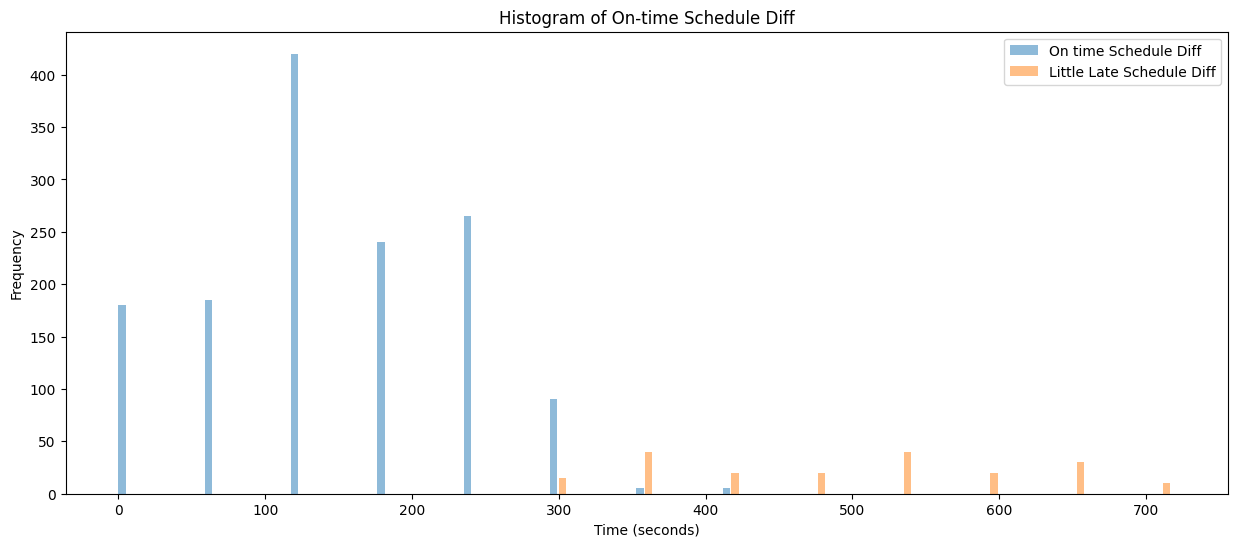

In [ ]:
#Pull data for on time and little late statuses
on_time_data = data.filter(pl.col('statusName') == 'On Time')
little_late_data = data.filter(pl.col('statusName') == 'Little Late')

#Convert the scheduleDiff to scheduleDiff_seconds
on_time_data = on_time_data.with_columns(
    (pl.col("scheduleDiff").dt.total_seconds()).alias("scheduleDiff_seconds") 
)

little_late_data = little_late_data.with_columns(
    (pl.col("scheduleDiff").dt.total_seconds()).alias("scheduleDiff_seconds") 
)


# Plot the histograms
plt.figure(figsize=(15, 6))
plt.hist(on_time_data['scheduleDiff_seconds'].to_list(), bins=50, alpha=0.5, width=5, label='On time Schedule Diff')
plt.hist(little_late_data['scheduleDiff_seconds'].to_list(), bins=50, alpha=0.5, width=5, label='Little Late Schedule Diff')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of On-time Schedule Diff')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Define a threshold for overlapping data in minutes
threshold = 5.0 * 60

# Filter out pairs where the difference in scheduleDiff_minutes is within the threshold
overlapping_data = data.filter(pl.col('scheduleDiff').dt.total_seconds() >= threshold).sort('scheduleDiff')

overlapping_data['routeID', 'equipmentID', 'receiveTime', 'schedule','statusName', 'scheduleDiff']

routeID,equipmentID,receiveTime,schedule,statusName,scheduleDiff
i64,str,datetime[ns],str,str,duration[μs]
12,"""72307""",2024-09-01 00:00:08,"""06:58PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:03PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:05PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:05PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:07PM""","""On Time""",5m
…,…,…,…,…,…
13,"""1102""",2024-08-31 11:36:01,"""08:01AM""","""Very Late""",10h 59m
13,"""1102""",2024-08-31 11:36:01,"""08:01AM""","""Very Late""",10h 59m
13,"""1102""",2024-08-31 11:36:01,"""08:02AM""","""Very Late""",10h 59m
